In [116]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [117]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from scipy.stats import norm
from tqdm.auto import tqdm

import sys
sys.path.append('../utils')
from utils import *

In [118]:
combined_df = retrieve_data()

# GARCH Model

GARCH (Generalized Autoregressive Conditional Heteroskedasticity) estimate the time-varying volatility of returns, which then can be used to generate stock prices based on those estimated volatilities. 

## Univariate

In [119]:
from arch import arch_model

In [120]:
tickers = ['ROG', 'CFR', 'ZURN']

In [121]:
for t in tickers:
    combined_df[f'{t}_return'] = np.log(combined_df[f'{t}_Last_Price'] / combined_df[f'{t}_Last_Price'].shift(1))

In [122]:
returns = combined_df['ROG_return'].dropna()

In [123]:
model = arch_model(returns, vol='Garch', p=1, q=1)
garch_fit = model.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2337862.521850468
Iteration:      2,   Func. Count:     17,   Neg. LLF: -13.661862827305733
Iteration:      3,   Func. Count:     26,   Neg. LLF: -748.7337823747991
Iteration:      4,   Func. Count:     32,   Neg. LLF: -750.7652300436187
Iteration:      5,   Func. Count:     38,   Neg. LLF: -750.8684483508705
Iteration:      6,   Func. Count:     43,   Neg. LLF: -741.7894529437544
Iteration:      7,   Func. Count:     49,   Neg. LLF: -750.8607426239159
Iteration:      8,   Func. Count:     55,   Neg. LLF: -750.8765762443128
Iteration:      9,   Func. Count:     61,   Neg. LLF: -750.8766488197562
Iteration:     10,   Func. Count:     67,   Neg. LLF: -750.8766366620114
Optimization terminated successfully    (Exit mode 0)
            Current function value: -750.8766604808386
            Iterations: 10
            Function evaluations: 77
            Gradient evaluations: 10


/home/bach/anaconda3/envs/mh4518/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001512. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [124]:
print(garch_fit.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:             ROG_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                750.877
Distribution:                  Normal   AIC:                          -1493.75
Method:            Maximum Likelihood   BIC:                          -1479.64
                                        No. Observations:                  252
Date:                Fri, Nov 01 2024   Df Residuals:                      251
Time:                        17:24:35   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         6.4483e-04  7.795e-04      0.827      0.408 

In [125]:
num_simulations = 10000
simulated_prices = []
last_price = combined_df['ROG_Last_Price'].iloc[-1]

In [126]:
from tqdm.auto import tqdm

In [127]:
for _ in tqdm(range(num_simulations)):
    simulated_returns = model.simulate(garch_fit.params, nobs=252)  # Simulate 252 days
    simulated_price = last_price * np.exp(np.cumsum(simulated_returns))  # Convert returns to prices
    simulated_prices.append(simulated_price)

  0%|          | 0/10000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
simulated_prices[1]

data   volatility      errors
0    277.923291   283.061443  277.744136
1    277.602350   286.565739  277.244568
2    277.370818   290.113418  276.834765
3    276.642273   293.705017  275.929643
4    284.301238   297.341081  283.386083
..          ...          ...         ...
247  352.358266  5912.041623  300.284550
248  354.347970  5985.232599  301.785540
249  364.306191  6059.329678  310.066597
250  356.799976  6134.344077  303.482185
251  351.296005  6210.287153  298.608076

[252 rows x 3 columns]

  0%|          | 0/10000 [00:00<?, ?it/s]

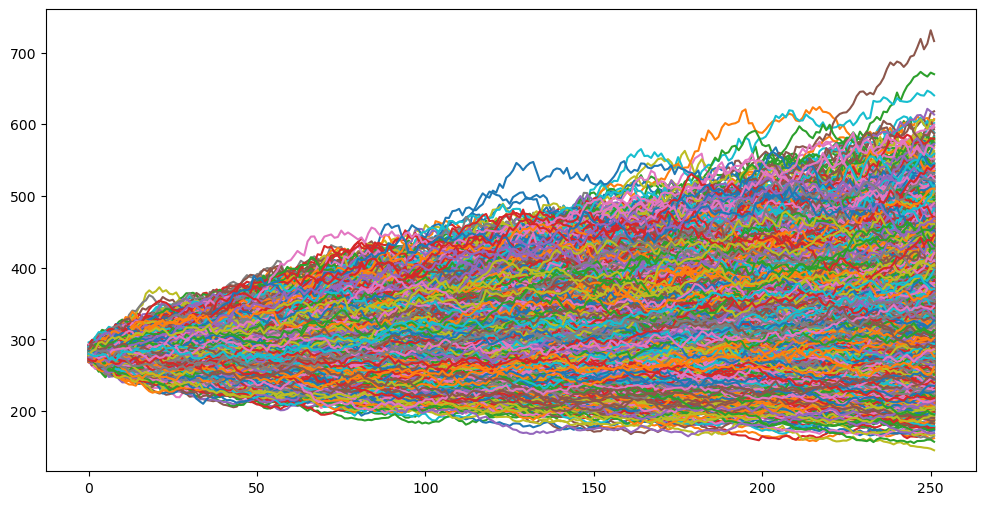

In [ ]:
f = plt.figure(figsize=(12,6))

for price in tqdm(simulated_prices):
    plt.plot(price['data'])

# Multivariate Black-Scholes model

The BS model implies that the market is defined by the two SDE describing the stock price and the bond price. We can utilize the equation for the stock price to simulate our assets price.

Under the risk-neutral assumption, our drift is equal to our risk-free rate, and to take into account the relationship between our 3 different assets, the volatility is the diagonal of the covariance matrix between the 3 assets' prices.

Risk neutral evaluation + No arbitrage technique
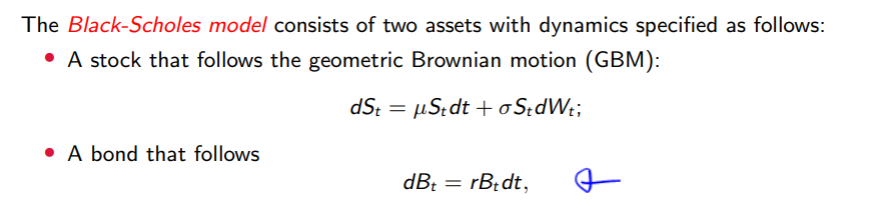

In [ ]:
np.random.seed(42)
n_days = 252
dt = 1 / n_days

In [ ]:
combined_df['Risk_Free_Rate'].head()

0    1.4594
1    1.4508
2    1.4478
3    1.4623
4    1.4489
Name: Risk_Free_Rate, dtype: float64

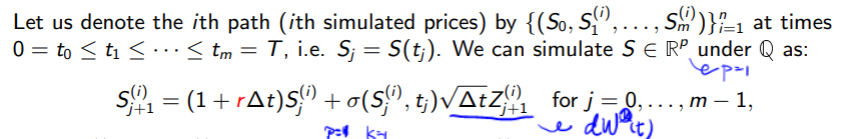

In [ ]:
close = combined_df[['ROG_Last_Price', 'CFR_Last_Price', 'ZURN_Last_Price']]
close.cov()

ROG_Last_Price  CFR_Last_Price  ZURN_Last_Price
ROG_Last_Price       375.344673      -17.563543       286.937174
CFR_Last_Price       -17.563543      133.176550       138.191785
ZURN_Last_Price      286.937174      138.191785       706.118284

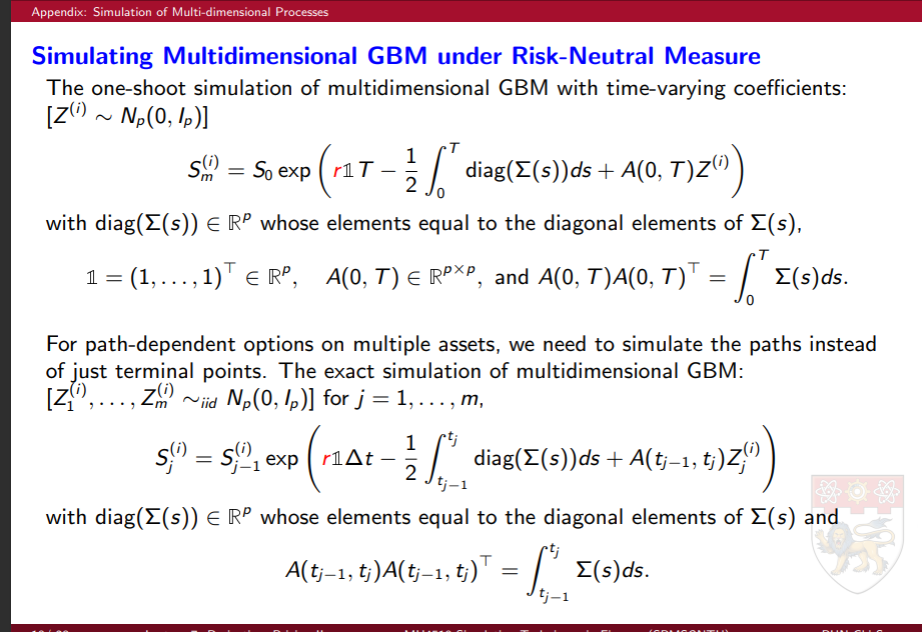

In [132]:
tickers = close.columns

In [133]:
log_returns = np.log((close / close.shift(1)).dropna())

In [147]:
# Simulating from start


def BlackScholesSimulation(s0=close.iloc[0], 
                           tickers=tickers,
                           dt=dt,
                           drift=combined_df['Risk_Free_Rate'].values / 100,
                           volatility=log_returns.cov() * n_days,
                           n_paths=10,
                           T=1, # Time horizon in year:
                           variance_reduction=None
                           ):
    
    n_steps = int(T / dt)
    result = np.zeros((len(tickers), n_paths, n_steps))

    if variance_reduction==None:
        for i in tqdm(range(n_paths)):
            choleskyMatrix = np.linalg.cholesky(volatility)
            e = np.random.normal(size=(len(tickers), n_steps)) # Generate RV for steps


            for j in range(n_steps):
                for k in range(len(tickers)):
                    if(j==0):
                        result[k, i, j] = s0[tickers[k]]
                    else:
                        if isinstance(drift, np.ndarray):
                            result[k, i, j] = result[k, i, j-1] * np.exp(
                                (drift[j] -  1/2 * np.sqrt(volatility.iloc[k, k])) * dt + 
                                np.sqrt(dt) * choleskyMatrix[k, k] * e[k, j])
                        else:
                            result[k, i, j] = result[k, i, j-1] * np.exp(
                                (drift -  1/2 * np.sqrt(volatility.iloc[k, k])) * dt + 
                                np.sqrt(dt) * choleskyMatrix[k, k] * e[k, j])
    
    elif variance_reduction=='antithetic' or variance_reduction=='av' or variance_reduction=='antithetic_variates':
        for i in tqdm(range(n_paths // 2)):
            choleskyMatrix = np.linalg.cholesky(volatility)
            e = np.random.normal(size=(len(tickers), n_steps)) # Generate RV for steps
            e_tilde = -e    

            for j in range(n_steps):
                for k in range(len(tickers)):
                    if(j==0):
                        result[k, i, j] = s0[tickers[k]]
                        result[k, n_paths - i - 1, j] = s0[tickers[k]]

                    else:
                        if isinstance(drift, np.ndarray):
                            result[k, i, j] = result[k, i, j-1] * np.exp(
                                (drift[j] -  1/2 * np.sqrt(volatility.iloc[k, k])) * dt + 
                                np.sqrt(dt) * choleskyMatrix[k, k] * e[k, j])
                            result[k, n_paths - i - 1, j] = result[k, n_paths - i - 1, j-1] * np.exp(
                                (drift[j] -  1/2 * np.sqrt(volatility.iloc[k, k])) * dt + 
                                np.sqrt(dt) * choleskyMatrix[k, k] * e_tilde[k, j])
                        else:
                            result[k, i, j] = result[k, i, j-1] * np.exp(
                                (drift -  1/2 * np.sqrt(volatility.iloc[k, k])) * dt + 
                                np.sqrt(dt) * choleskyMatrix[k, k] * e[k, j])
                            result[k, n_paths - i - 1, j] = result[k, n_paths - i - 1, j-1] * np.exp(
                                (drift -  1/2 * np.sqrt(volatility.iloc[k, k])) * dt + 
                                np.sqrt(dt) * choleskyMatrix[k, k] * e_tilde[k, j])
    elif variance_reduction=='emc' or variance_reduction=='emperical_martingale_correction':
        for i in tqdm(range(n_paths)):
            choleskyMatrix = np.linalg.cholesky(volatility)
            e = np.random.normal(size=(len(tickers), n_steps)) # Generate RV for steps


            for j in range(n_steps):
                for k in range(len(tickers)):
                    if(j==0):
                        result[k, i, j] = s0[tickers[k]]
                    else:
                        if isinstance(drift, np.ndarray):
                            result[k, i, j] = result[k, i, j-1] * np.exp(
                                (drift[j] -  1/2 * np.sqrt(volatility.iloc[k, k])) * dt + 
                                np.sqrt(dt) * choleskyMatrix[k, k] * e[k, j])
                        else:
                            result[k, i, j] = result[k, i, j-1] * np.exp(
                                (drift -  1/2 * np.sqrt(volatility.iloc[k, k])) * dt + 
                                np.sqrt(dt) * choleskyMatrix[k, k] * e[k, j])
        for k in range(len(tickers)):  
                # path, step
            correction_factor = result[k][-1, :].mean() / result[k][-1, :] 
            result[k] = result[k] * correction_factor                    
           

    
    return result, tickers


        


In [149]:
result_emc, _ = BlackScholesSimulation(s0=close.iloc[187],
                                         n_paths=1000,
                                         T=dt * 65,
                                         volatility=log_returns.cov() * n_days,
                                         variance_reduction='emc')

result, _ = BlackScholesSimulation(s0=close.iloc[187],
                                         n_paths=1000,
                                         T=dt * 65,
                                         volatility=log_returns.cov() * n_days,
                                         variance_reduction=None)

result_av, _ = BlackScholesSimulation(s0=close.iloc[187],
                                         n_paths=1000,
                                         T=dt * 65,
                                         volatility=log_returns.cov() * n_days,
                                         variance_reduction='av')

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [150]:
print(f'''{tickers[0]}: \n\tmean:{np.mean(result[0][:, -1])}\n\tvariance:{np.var(result[0][:, -1])}\n{tickers[1]}: \n\tmean:{np.mean(result[1][:, -1])}\n\tvariance:{np.var(result[1][:, -1])}\n{tickers[2]}: \n\tmean:{np.mean(result[2][:, -1])}\n\tvariance:{np.var(result[2][:, -1])}''')

ROG_Last_Price: 
	mean:273.1885332539328
	variance:697.1621901500788
CFR_Last_Price: 
	mean:128.6309404007642
	variance:383.62633009047136
ZURN_Last_Price: 
	mean:468.7197722393213
	variance:804.7893110517932


In [151]:
print(f'''{tickers[0]}: \n\tmean:{np.mean(result_emc[0][:, -1])}\n\tvariance:{np.var(result_emc[0][:, -1])}\n{tickers[1]}: \n\tmean:{np.mean(result_emc[1][:, -1])}\n\tvariance:{np.var(result_emc[1][:, -1])}\n{tickers[2]}: \n\tmean:{np.mean(result_emc[2][:, -1])}\n\tvariance:{np.var(result_emc[2][:, -1])}''')

ROG_Last_Price: 
	mean:275.0874712500222
	variance:735.7694567718885
CFR_Last_Price: 
	mean:138.983713345464
	variance:407.0519487335352
ZURN_Last_Price: 
	mean:461.9654779797528
	variance:779.4285336280453


In [152]:
print(f'''{tickers[0]}: \n\tmean:{np.mean(result_av[0][:, -1])}\n\tvariance:{np.var(result_av[0][:, -1])}\n{tickers[1]}: \n\tmean:{np.mean(result_av[1][:, -1])}\n\tvariance:{np.var(result_av[1][:, -1])}\n{tickers[2]}: \n\tmean:{np.mean(result_av[2][:, -1])}\n\tvariance:{np.var(result_av[2][:, -1])}''')

ROG_Last_Price: 
	mean:273.00580697541625
	variance:744.8239199952234
CFR_Last_Price: 
	mean:128.27784298904328
	variance:342.00440098344365
ZURN_Last_Price: 
	mean:469.04050402552826
	variance:869.8796836384081


## Plotting path

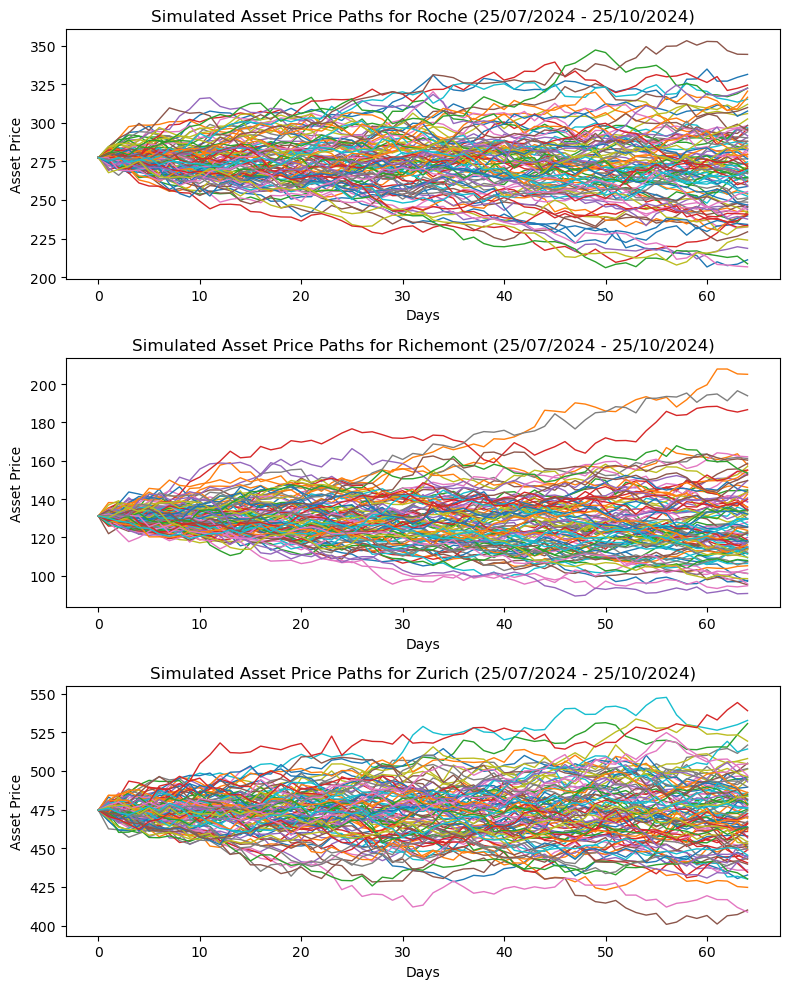

In [153]:
fig, axes = plt.subplots(3, 1, figsize=(8, 10))

for i in range(100):
    axes[0].plot(result[0][i], lw=1)
axes[0].set_title('Simulated Asset Price Paths for Roche (25/07/2024 - 25/10/2024)')
axes[0].set_xlabel('Days')
axes[0].set_ylabel('Asset Price')

for i in range(100):
    axes[1].plot(result[1][i], lw=1)
axes[1].set_title('Simulated Asset Price Paths for Richemont (25/07/2024 - 25/10/2024)')
axes[1].set_xlabel('Days')
axes[1].set_ylabel('Asset Price')

for i in range(100):
    axes[2].plot(result[2][i], lw=1)
axes[2].set_title('Simulated Asset Price Paths for Zurich (25/07/2024 - 25/10/2024)')
axes[2].set_xlabel('Days')
axes[2].set_ylabel('Asset Price')

plt.tight_layout()
plt.show()

## Average payoff

In [154]:
import sys
sys.path.append('../utils/')
from payoff import *

payoff = []
payoff_av = []
payoff_emc = []
for i in range(result.shape[1]):
    payoff.append(payoff_func(result[0][i], result[1][i], result[2][i]))
    payoff_av.append(payoff_func(result_av[0][i], result_av[1][i], result_av[2][i]))
    payoff_emc.append(payoff_func(result_emc[0][i], result_emc[1][i], result_emc[2][i]))


Hello
Worst performance: 0.7736589913873353
Barrier event reached: False
Close above initial: 1
Hello
Worst performance: 1.004219785740497
Barrier event reached: False
Close above initial: 3
Hello
Worst performance: 0.8579361625054762
Barrier event reached: False
Close above initial: 1
Hello
Worst performance: 0.9422006998144148
Barrier event reached: False
Close above initial: 2
Hello
Worst performance: 0.8250106172506378
Barrier event reached: False
Close above initial: 2
Hello
Worst performance: 0.9731631007565452
Barrier event reached: False
Close above initial: 2
Hello
Worst performance: 0.9701998638881247
Barrier event reached: False
Close above initial: 2
Hello
Worst performance: 0.9241820660066713
Barrier event reached: False
Close above initial: 2
Hello
Worst performance: 0.9016568395737452
Barrier event reached: False
Close above initial: 2
Hello
Worst performance: 0.9044944798670717
Barrier event reached: False
Close above initial: 2
Hello
Worst performance: 0.84948175467170

In [155]:
np.mean(payoff), np.std(payoff)

(1087.0498335484224, 14.228393594914118)

In [156]:
np.mean(payoff_av), np.std(payoff_av)

(1087.5, 0.0)

In [157]:
np.mean(payoff_emc), np.std(payoff_emc)

(1087.5, 0.0)

# Simulate longer period

In [158]:
result, _ = BlackScholesSimulation(s0=close.iloc[0],
                                         n_paths=10000,
                                         T=dt * 252,
                                         volatility=log_returns.cov() * n_days,
                                         variance_reduction=None)

result_emc, _ = BlackScholesSimulation(s0=close.iloc[0],
                                         n_paths=10000,
                                         T=dt * 252,
                                         volatility=log_returns.cov() * n_days,
                                         variance_reduction='emc')

result_av, _ = BlackScholesSimulation(s0=close.iloc[0],
                                         n_paths=10000,
                                         T=dt * 252,
                                         volatility=log_returns.cov() * n_days,
                                         variance_reduction='av')

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

In [159]:
print(f'''{tickers[0]}: \n\tmean:{np.mean(result[0][:, -1])}\n\tvariance:{np.var(result[0][:, -1])}\n{tickers[1]}: \n\tmean:{np.mean(result[1][:, -1])}\n\tvariance:{np.var(result[1][:, -1])}\n{tickers[2]}: \n\tmean:{np.mean(result[2][:, -1])}\n\tvariance:{np.var(result[2][:, -1])}''')

ROG_Last_Price: 
	mean:221.91702491639126
	variance:1906.3389270403325
CFR_Last_Price: 
	mean:97.4371410469146
	variance:788.8273842421922
ZURN_Last_Price: 
	mean:406.1471623401318
	variance:2507.3434872316175


In [161]:
print(f'''{tickers[0]}: \n\tmean:{np.mean(result_emc[0][:, -1])}\n\tvariance:{np.var(result_emc[0][:, -1])}\n{tickers[1]}: \n\tmean:{np.mean(result_emc[1][:, -1])}\n\tvariance:{np.var(result_emc[1][:, -1])}\n{tickers[2]}: \n\tmean:{np.mean(result_emc[2][:, -1])}\n\tvariance:{np.var(result_emc[2][:, -1])}''')

ROG_Last_Price: 
	mean:228.8228989045511
	variance:2064.4403845905945
CFR_Last_Price: 
	mean:118.09389918322445
	variance:1202.8162380287065
ZURN_Last_Price: 
	mean:498.2133152838922
	variance:3814.653200203143


In [160]:
print(f'''{tickers[0]}: \n\tmean:{np.mean(result_av[0][:, -1])}\n\tvariance:{np.var(result_av[0][:, -1])}\n{tickers[1]}: \n\tmean:{np.mean(result_av[1][:, -1])}\n\tvariance:{np.var(result_av[1][:, -1])}\n{tickers[2]}: \n\tmean:{np.mean(result_av[2][:, -1])}\n\tvariance:{np.var(result_av[2][:, -1])}''')

ROG_Last_Price: 
	mean:222.00138499110443
	variance:1875.2226488847907
CFR_Last_Price: 
	mean:97.65406762412535
	variance:794.862627066996
ZURN_Last_Price: 
	mean:405.865091996273
	variance:2486.0500238563095


In [162]:
import sys
sys.path.append('../utils/')
from payoff import *

payoff = []
payoff_av = []
payoff_emc = []
for i in range(result.shape[1]):
    payoff.append(payoff_func(result[0][i], result[1][i], result[2][i]))
    payoff_av.append(payoff_func(result_av[0][i], result_av[1][i], result_av[2][i]))
    payoff_emc.append(payoff_func(result_emc[0][i], result_emc[1][i], result_emc[2][i]))

Hello
Worst performance: 0.6791894921867281
Barrier event reached: False
Close above initial: 0
Hello
Worst performance: 0.49519060894511535
Barrier event reached: True
Close above initial: 1
Hello
Worst performance: 0.7312650710514256
Barrier event reached: False
Close above initial: 0
Hello
Worst performance: 0.5082710383357426
Barrier event reached: True
Close above initial: 1
Hello
Worst performance: 0.987070976410294
Barrier event reached: False
Close above initial: 2
Hello
Worst performance: 0.716558836360886
Barrier event reached: False
Close above initial: 2
Hello
Worst performance: 0.6765979132681741
Barrier event reached: True
Close above initial: 0
Hello
Worst performance: 0.9590036698662604
Barrier event reached: False
Close above initial: 2
Hello
Worst performance: 0.7279634312660818
Barrier event reached: True
Close above initial: 1
Hello
Worst performance: 0.2810073492290007
Barrier event reached: True
Close above initial: 0
Hello
Worst performance: 0.7987793119013845
Ba

In [163]:
np.mean(payoff), np.std(payoff)

(922.1697995661085, 217.70590089705937)

In [164]:
np.mean(payoff_av), np.std(payoff_av)

(921.8591836189336, 216.93751529235547)

In [165]:
np.mean(payoff_emc), np.std(payoff_emc)

(942.7087275445713, 174.59144564619137)